# Permutation Models for Bayesian Performance Analysis

In this notebook we implement several probabilistic models on permutations to be used in a Bayesian inference framework for performance analysis. The notebook is divided in the following sections:

* Preliminaries section installs and configures all the dependendencies required by the notebook.
* Syntetic Data section contains a few tests of the Bayesian analysis carried out using syntetically generated permutation datasets.
* Real Data section contains a Bayesian analysis carried out using real data comming from the comparison of several algorithms on several instances of the FlowShop Schedule Problem. See Ceberio et al. [1] for further details.

## Index of figures

Figures presented in the original paper. Click in the link to jump directly to the figure within this notebook.

* [Fig. 1](#fig-1): Probability of each algorithm to be the top-ranked algorithm using synthetically generated data. Each plot represents a different algorithm while the values represented in the horizontal axis within each plot correspond with the marginal probability estimation provided by the different Bayesian inference models.

* [Fig. 2](#fig-2): Probability of each algorithm to outperform others. We show the results obtained with the BT model. Each plot represents the probability that the algorithm in the center outperforms the others in the outer ring of the polar coordinate system.

* [Fig. 3](#fig-3): Probability of each algorithm to be in the top- 2  and top- 3  ranking. The values in the horizontal axis within each plot represent the marginal probability for the different algorithms.

* [Fig. 4](#fig-4): Histograms showing the number of permutations in the sample at different Kendall's-tau distances from the modal ranking.

* [Fig. 5](#fig-5): Probability of algorithm  A1  to be the top-ranked algorithm using different configurations of synthetically generated data.

* [Fig. 6](#fig-6). Probability of each algorithm to be the top-ranked algorithm using the PSFP benchmark. Each plot represents a different algorithm while the values represented in the horizontal axis within each plot are the marginal probability estimation provided by the different Bayesian inference models.

* [Fig. 7](#fig-7): Probability of each algorithm to outperform others using the PSFP benchmark. In the first row, we show the results obtained with the BT model and in the second row for the MM. Each plot represents the probability that the algorithm in the center outperforms the other algorithms in the outer ring of the polar coordinate system.

* [Fig. 8](#fig-9) Probability of algorithm GM-EDA to be the top-ranked algorithm as we take different numbers of permutations to perform the Bayesian inferences, i.e., $p=\{100, 500, 1000, 2000\}$

## Preliminaries

### Install pre-requisites

You should have installed in your computer:
* BayesMallows: an R package, https://cran.r-project.org/web/packages/BayesMallows/index.html
* rpy2 (`pip install rpy2`): used by BayesPermus
* BayesPermus (`pip install BayesPermus`): our Pyhon package, https://pypi.org/project/BayesPermus/

### General imports

In [1]:
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import numpy as np

In [2]:
import matplotlib

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [ ]:
from BayesPermus.models.PlackettLuce import PlackettLuceDirichlet
from BayesPermus.models.PlackettLuce import PlackettLuceGamma
from BayesPermus.models.BradleyTerry import BradleyTerry
from BayesPermus.models.MallowsModel import MallowsModel
from BayesPermus.figure.plot import Plot

### Random Seed

Random seed for the generation of random numbers. We use this seed for the Bayesian inference (passed to BayesPermus) and for the generation of the synthetic data as well.

In [4]:
seed = 1

In [5]:
np.random.seed(seed)

In [6]:
bradleyTerry = BradleyTerry([1], num_samples=1000, seed=seed)
placettLuceDirichlet = PlackettLuceDirichlet(alpha=[1], num_samples=1000, seed=seed)
placettLuceGamma = PlackettLuceGamma(alpha=0.5, beta=0.5, num_samples=1000, seed=seed)
mallowsModel = MallowsModel(num_samples=1000, seed=seed)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_066c9b0cc9656fcb03ae80f71e016399 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2e475dd78cdb979098a6ff696f8c2180 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_02ad7b318e3fbca24dc0149c1b4af0f5 NOW.


## Case of study

### Preliminaries

#### Functions to calculate the marginal probabilities

We are leaving the following auxiliary functions on the main body of the notebook as an example how to use BayesPermus library.

In [7]:
def calculate_top_ranking_probs(orderings, num_samples=1000):
  num_instances, num_algorithms = orderings.shape

  # Priors definition
  dirichlet_alpha_bt = num_algorithms * [1]
  dirichlet_alpha_pl = num_algorithms * [1]
  gamma_alpha_pl = 0.5
  gamma_beta_pl = 0.5
    
  # Update model priors and other hyper-parameters
  bradleyTerry.alpha = dirichlet_alpha_bt
  bradleyTerry.num_samples = num_samples
  placettLuceDirichlet.alpha = dirichlet_alpha_pl
  placettLuceDirichlet.num_samples = num_samples
  placettLuceGamma.alpa = gamma_alpha_pl
  placettLuceGamma.beta = gamma_beta_pl
  placettLuceGamma.num_samples = num_samples
  mallowsModel.num_samples = num_samples
  
  # Obtain the posterior summaries
  pld = placettLuceDirichlet.calculate_top_ranking_probs(orderings)
  plg = placettLuceGamma.calculate_top_ranking_probs(orderings)
  bt  = bradleyTerry.calculate_top_ranking_probs(orderings)
  mm  = mallowsModel.calculate_top_ranking_probs(orderings)

  return bt, pld, plg, mm

In [8]:
def calculate_better_than_probs(orderings, num_samples=1000):
  num_instances, num_algorithms = orderings.shape

  # Priors definition
  dirichlet_alpha_bt = num_algorithms * [1]
  dirichlet_alpha_pl = num_algorithms * [1]
  gamma_alpha_pl = 0.5
  gamma_beta_pl = 0.5
    
  # Update model priors and other hyper-parameters
  bradleyTerry.alpha = dirichlet_alpha_bt
  bradleyTerry.num_samples = num_samples
  placettLuceDirichlet.alpha = dirichlet_alpha_pl
  placettLuceDirichlet.num_samples = num_samples
  placettLuceGamma.alpa = gamma_alpha_pl
  placettLuceGamma.beta = gamma_beta_pl
  placettLuceGamma.num_samples = num_samples
  mallowsModel.num_samples = num_samples
  
  # Obtain the posterior summaries
  pld = placettLuceDirichlet.calculate_better_than_probs(orderings)
  plg = placettLuceGamma.calculate_better_than_probs(orderings)
  bt  = bradleyTerry.calculate_better_than_probs(orderings)
  mm  = mallowsModel.calculate_better_than_probs(orderings)

  return bt, pld, plg, mm

In [9]:
def calculate_top_k_probs(orderings, num_samples=1000):
  num_instances, num_algorithms = orderings.shape

  # Priors definition
  dirichlet_alpha_bt = num_algorithms * [1]
  dirichlet_alpha_pl = num_algorithms * [1]
  gamma_alpha_pl = 0.5
  gamma_beta_pl = 0.5
    
  # Update model priors and other hyper-parameters
  bradleyTerry.alpha = dirichlet_alpha_bt
  bradleyTerry.num_samples = num_samples
  placettLuceDirichlet.alpha = dirichlet_alpha_pl
  placettLuceDirichlet.num_samples = num_samples
  placettLuceGamma.alpa = gamma_alpha_pl
  placettLuceGamma.beta = gamma_beta_pl
  placettLuceGamma.num_samples = num_samples
  mallowsModel.num_samples = num_samples
  
  # Obtain the posterior summaries
  pld = placettLuceDirichlet.calculate_top_k_probs(orderings)
  plg = placettLuceGamma.calculate_top_k_probs(orderings)
  bt  = bradleyTerry.calculate_top_k_probs(orderings)
  mm  = mallowsModel.calculate_top_k_probs(orderings)

  return bt, pld, plg, mm

#### Functions to provide additional formatting to the different plots

In [10]:
from utils.PlotCustomFormats import *

#### Functions to calculate the empirical probabilities from a set of permutations

In [11]:
from utils.EmpiricalMarginals import *

**Functions to tabulate numerical results:**

In [12]:
from utils.Tables import *

## Syntetic Data Analyses

In [13]:
from utils.Synthetic import *

### Simple example

In [14]:
# number of instances (permutations) to synthetically generate
num_instances = 1000

# Each entry represent the mean and standard deviation of
# a normally distributed r.v. that represents the score of
# diferent algorithms.
mean = [2.0, 4.0, 6.0, 8.0]
std  = [1.0, 1.0, 1.0, 1.0]

# Generate the scores for the different algorithms using
# the previously defined parameters.
scores = synthetic(num_instances, mean, std)

# Obtain orderings and rankings from the scores.
orderings = np.argsort(scores, axis=1) + 1
rankings = np.argsort(orderings, axis=1) + 1

In [15]:
# Names of the different Bayesian models on permutation spaces.
# Mainly used for ploting.
model_names=['BT', 'PLD', 'PLG', 'MM']

# Names of the different synthetically generated algorithms.
# Mainly used for ploting.
algorithm_names=['$A_1$', '$A_2$', '$A_3$', '$A_4$']

In [16]:
# Obtain the empirical probabilities from the raw generated data.
p_top_ranking = empirical_top_ranking_probs(orderings)
p_better_than = empirical_better_than(orderings)
p_top_k = empirical_top_k(orderings)

**Probability of an algorithm to be in the first ranking:**<a id="fig-1"></a>

Fig. 1: Probability of each algorithm to be the top-ranked algorithm using synthetically generated data. Each plot represents a different algorithm while the values represented in the horizontal axis within each plot correspond with the marginal probability estimation provided by the different Bayesian inference models.

In [17]:
probs = calculate_top_ranking_probs(orderings)

<Figure size 432x288 with 0 Axes>

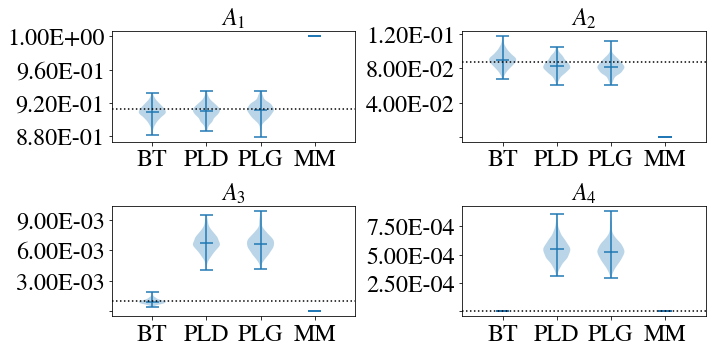

In [18]:
fig = plt.figure()
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
flat_axs = list(itertools.chain.from_iterable(axs))

plotter = Plot()
plotter.plot_top_ranking_probs(model_names, algorithm_names, probs, p_top_ranking, flat_axs)

format_regular_coordinate_axis(flat_axs)
plt.tight_layout()

fig.savefig("img/TopOneSynthetic.pdf", bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

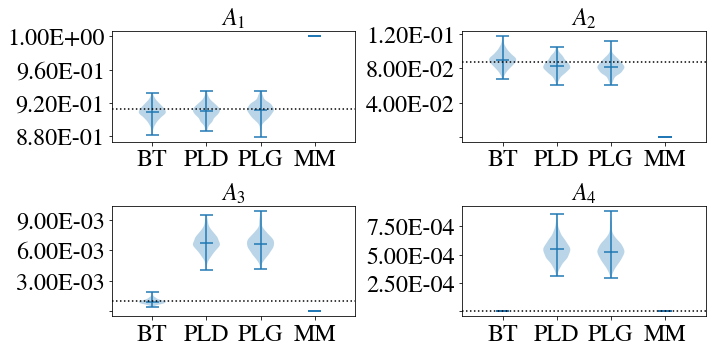

In [19]:
fig = plt.figure()
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
flat_axs = list(itertools.chain.from_iterable(axs))

plotter = Plot()
plotter.plot_top_ranking_probs(model_names, algorithm_names, probs, p_top_ranking, flat_axs)

format_regular_coordinate_axis(flat_axs)
plt.tight_layout()

fig.savefig("img/TopOneSynthetic.pdf", bbox_inches='tight')

**Numerical results:**

In [20]:
data = tabuleTopOne(probs)
index = model_names
df = pd.DataFrame(data, columns=algorithm_names, index=index)
df.to_latex("tables/TopOneSynthetic.tex")
df

,$A_1$,$A_2$,$A_3$,$A_4$
BT,9.09E-01 (8.84E-03),8.99E-02 (8.74E-03),9.73E-04 (2.38E-04),7.26E-07 (3.58E-07)
PLD,9.10E-01 (9.10E-03),8.30E-02 (8.48E-03),6.79E-03 (9.14E-04),5.47E-04 (9.43E-05)
PLG,9.11E-01 (8.67E-03),8.17E-02 (8.03E-03),6.66E-03 (9.31E-04),5.26E-04 (9.11E-05)
MM,1.00E+00 (8.75E-06),3.86E-05 (8.75E-06),1.56E-09 (7.30E-10),6.66E-14 (4.90E-14)


**Probability of an algorithm to be better than another:**<a id="fig-2"></a>

Fig. 2: Probability of each algorithm to outperform others. We show the results obtained with the BT model. Each plot represents the probability that the algorithm in the center outperforms the others in the outer ring of the polar coordinate system.

In [21]:
probs = calculate_better_than_probs(orderings)

<Figure size 432x288 with 0 Axes>

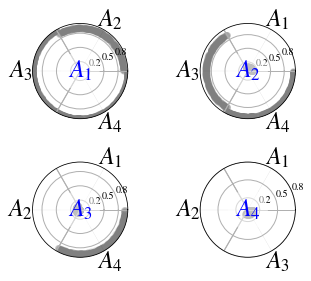

In [22]:
fig = plt.figure()
fig, axs = plt.subplots(2, 2, figsize=(5, 4), subplot_kw=dict(projection='polar'))
flat_axs = list(itertools.chain.from_iterable(axs))

plotter = Plot()
plotter.plot_better_than_probs(algorithm_names, probs[0], p_better_than, flat_axs)

format_polar_coordinate_axis(flat_axs)
plt.tight_layout()

fig.savefig("img/BetterThanSynthetic.pdf", bbox_inches='tight')

**Numerical results:**

In [23]:
data = tabuleBetterThan(probs)
tuples = itertools.product(model_names, algorithm_names)
index = pd.MultiIndex.from_tuples(tuples, names=["Model", "Algorithm"])
df = pd.DataFrame(data, columns=algorithm_names, index=index)
df.to_latex("tables/BetterThanSynthetic.tex")
df

$A_1$                $A_2$  \
Model Algorithm                                             
BT    $A_1$      0.00E+00 (0.00E+00)  9.10E-01 (8.76E-03)   
      $A_2$      9.00E-02 (8.76E-03)  0.00E+00 (0.00E+00)   
      $A_3$      1.88E-03 (4.27E-04)  7.99E-02 (8.29E-03)   
      $A_4$      8.75E-06 (3.08E-06)  1.37E-03 (3.53E-04)   
PLD   $A_1$      0.00E+00 (0.00E+00)  9.16E-01 (8.59E-03)   
      $A_2$      8.36E-02 (8.59E-03)  0.00E+00 (0.00E+00)   
      $A_3$      7.41E-03 (1.04E-03)  7.57E-02 (7.72E-03)   
      $A_4$      6.01E-04 (1.07E-04)  6.56E-03 (1.00E-03)   
PLG   $A_1$      0.00E+00 (0.00E+00)  9.18E-01 (8.14E-03)   
      $A_2$      8.22E-02 (8.14E-03)  0.00E+00 (0.00E+00)   
      $A_3$      7.26E-03 (1.06E-03)  7.54E-02 (7.83E-03)   
      $A_4$      5.77E-04 (1.03E-04)  6.41E-03 (9.73E-04)   
MM    $A_1$      0.00E+00 (0.00E+00)  1.00E+00 (8.75E-06)   
      $A_2$      3.86E-05 (8.75E-06)  0.00E+00 (0.00E+00)   
      $A_3$      3.13E-09 (1.46E-09)  3.86E-05 (8.75E-06)   
      $A_4$      2.00E-13 (1.47E-13)  3.13E-09 (1.46E-09)   

                               $A_3$                $A_4$  
Model Algorithm                                            
BT    $A_1$      9.98E-01 (4.27E-04)  1.00E+00 (3.08E-06)  
      $A_2$      9.20E-01 (8.29E-03)  9.99E-01 (3.53E-04)  
      $A_3$      0.00E+00 (0.00E+00)  9.26E-01 (8.38E-03)  
      $A_4$      7.39E-02 (8.38E-03)  0.00E+00 (0.00E+00)  
PLD   $A_1$      9.93E-01 (1.04E-03)  9.99E-01 (1.07E-04)  
      $A_2$      9.24E-01 (7.72E-03)  9.93E-01 (1.00E-03)  
      $A_3$      0.00E+00 (0.00E+00)  9.26E-01 (7.48E-03)  
      $A_4$      7.45E-02 (7.48E-03)  0.00E+00 (0.00E+00)  
PLG   $A_1$      9.93E-01 (1.06E-03)  9.99E-01 (1.03E-04)  
      $A_2$      9.25E-01 (7.83E-03)  9.94E-01 (9.73E-04)  
      $A_3$      0.00E+00 (0.00E+00)  9.27E-01 (8.25E-03)  
      $A_4$      7.33E-02 (8.25E-03)  0.00E+00 (0.00E+00)  
MM    $A_1$      1.00E+00 (1.46E-09)  1.00E+00 (1.47E-13)  
      $A_2$      1.00E+00 (8.75E-06)  1.00E+00 (1.46E-09)  
      $A_3$      0.00E+00 (0.00E+00)  1.00E+00 (8.75E-06)  
      $A_4$      3.86E-05 (8.75E-06)  0.00E+00 (0.00E+00)

**Probability of an algorithm to be in the top-k ranking:**<a id="fig-3"></a>

Fig. 3: Probability of each algorithm to be in the top-$2$ and top-$3$ ranking. The values in the horizontal axis within each plot represent the marginal probability for the different algorithms.

In [24]:
probs = calculate_top_k_probs(orderings)

<Figure size 432x288 with 0 Axes>

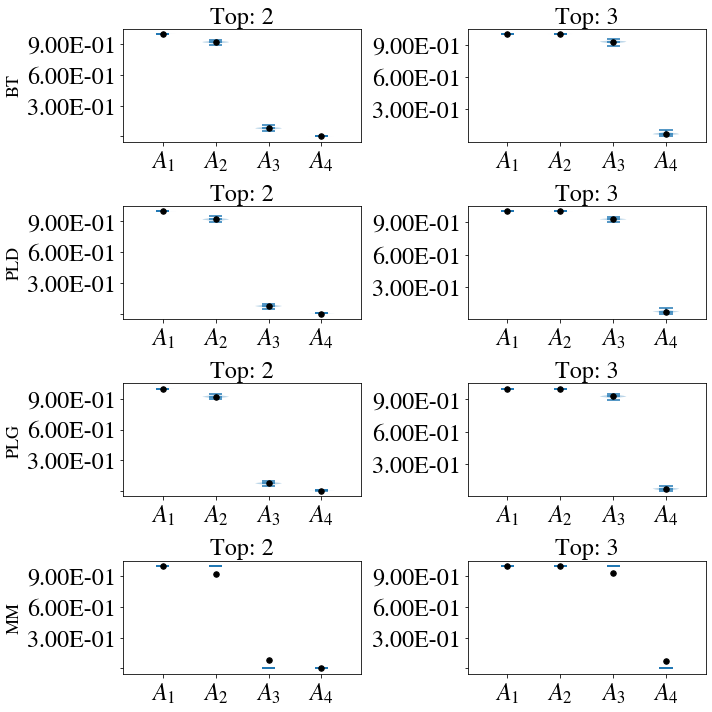

In [25]:
fig = plt.figure()
fig, axs = plt.subplots(4, 2, figsize=(10, 10))

for i, row in enumerate(axs):
    row[0].set_ylabel(model_names[i], fontsize=18)
    flat_axs = [None] + list(row) + [None]
    plotter = Plot()
    plotter.plot_top_k_probs(algorithm_names, probs[i], p_top_k, flat_axs)
    format_regular_coordinate_axis(flat_axs)

plt.tight_layout()
fig.savefig("img/TopKSynthetic.pdf", bbox_inches='tight')

**Numerical results:**

In [26]:
data = tabuleTopK(probs)
tuples = itertools.product(model_names, algorithm_names)
index = pd.MultiIndex.from_tuples(tuples, names=["Model", "Algorithm"])
df = pd.DataFrame(data, columns=["Top 2", "Top 3"], index=index)
df.to_latex("tables/TopKSynthetic.tex")
df

Top 2                Top 3
Model Algorithm                                          
BT    $A_1$      9.99E-01 (2.40E-04)  1.00E+00 (4.59E-07)
      $A_2$      9.20E-01 (8.33E-03)  9.99E-01 (2.04E-04)
      $A_3$      8.08E-02 (8.36E-03)  9.26E-01 (8.36E-03)
      $A_4$      6.68E-04 (1.87E-04)  7.46E-02 (8.46E-03)
PLD   $A_1$      9.99E-01 (2.79E-04)  1.00E+00 (7.74E-07)
      $A_2$      9.19E-01 (8.21E-03)  9.99E-01 (2.24E-04)
      $A_3$      7.58E-02 (7.67E-03)  9.26E-01 (7.43E-03)
      $A_4$      6.11E-03 (8.99E-04)  7.50E-02 (7.53E-03)
PLG   $A_1$      9.99E-01 (2.73E-04)  1.00E+00 (7.20E-07)
      $A_2$      9.20E-01 (8.23E-03)  9.99E-01 (2.13E-04)
      $A_3$      7.56E-02 (7.80E-03)  9.27E-01 (8.21E-03)
      $A_4$      5.97E-03 (8.76E-04)  7.37E-02 (8.30E-03)
MM    $A_1$      1.00E+00 (7.30E-10)  1.00E+00 (4.91E-14)
      $A_2$      1.00E+00 (8.75E-06)  1.00E+00 (7.30E-10)
      $A_3$      3.86E-05 (8.75E-06)  1.00E+00 (8.75E-06)
      $A_4$      1.56E-09 (7.30E-10)  3.86E-05 (8.75E-06)

### Effect of multimodal distributions 

This section of the notebook contains the figures and details of section IV.A-2.

**Generate empirical distributions using different standard deviations:**

In [27]:
stds = [2.0, 4.0, 12.0]

Lscores = []
Lorderings = []
Lrankings = []

for i, std in enumerate(stds):
  num_instances = 1000
  mean = [2.0, 4.0, 6.0, 8.0]
  std  = [std, 1.0, 1.0, std]

  scores = synthetic(num_instances, mean, std)
  orderings = np.argsort(scores, axis=1) + 1
  rankings = np.argsort(orderings, axis=1) + 1

  Lscores.append(scores)
  Lorderings.append(orderings)
  Lrankings.append(rankings)

**Histograms of the empirical distributions:**<a id="fig-4"></a>

Fig. 4: Histograms showing the number of permutations in the sample at different Kendall's-tau distances from the modal ranking.

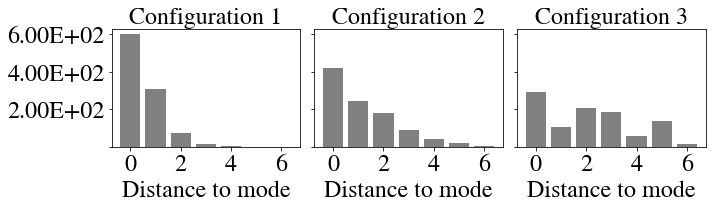

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True)

for config, (rankings, ax) in enumerate(zip(Lrankings, axs)):
  hist = calculate_hist(rankings)
  plot_hist(6, hist, ax, title='Configuration ' + str(config + 1))
    
format_regular_coordinate_axis(axs)
plt.tight_layout()

fig.savefig('img/Hist.pdf', bbox_inches='tight')

**Probability of an algorithm to be in the first ranking:**<a id="fig-5"></a>

Fig. 5: Probability of algorithm $A_1$ to be the top-ranked algorithm using different configurations of synthetically generated data.

In [29]:
probs_per_config = []
for config, orderings in enumerate(Lorderings):
  probs = calculate_top_ranking_probs(orderings)
  probs_per_config.append(probs)

<Figure size 432x288 with 0 Axes>

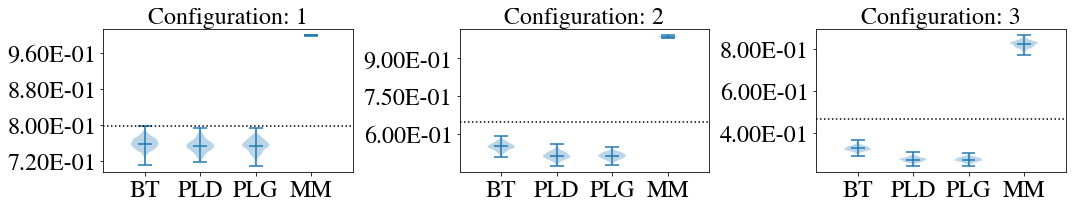

In [30]:
fig = plt.figure()
fig, axs = plt.subplots(1, 3, figsize=(15, 3))
flat_axs = axs

plotter = Plot()

for i, (probs, orderings, ax) in enumerate(zip(probs_per_config, Lorderings, flat_axs)):
    p_top_ranking = empirical_top_ranking_probs(orderings)
    plotter.plot_top_ranking_probs(model_names, algorithm_names, probs, p_top_ranking, [ax, None, None, None])
    ax.set_title("Configuration: " + str(i + 1))

format_regular_coordinate_axis(flat_axs)
plt.tight_layout()

fig.savefig("img/TopOneMultimodalSynthetic.pdf", bbox_inches='tight')

**Numerical results:**

In the following table we report the extended results of the previous figure but for all the remaining algorithms. In general, we can observe the same trends than in the figure, that is, as the empirical distribution of the permutations is less unimodal the Bayesian inferences are less similar to the ground truth.

In [31]:
for i, probs in enumerate(probs_per_config):
    data = tabuleTopOne(probs)
    index = model_names
    
    tuples = itertools.product(["Configuration " + str(i + 1)], algorithm_names)
    columns = pd.MultiIndex.from_tuples(tuples, names=["", "Algorithm"])
    
    df = pd.DataFrame(data, columns=columns, index=index)
    
    if i == 0:
        df_joint = df
    else:
        df_joint = pd.concat([df_joint, df], axis=1)

In [32]:
df_joint

Configuration 1                                            \
Algorithm                $A_1$                $A_2$                $A_3$   
BT         7.59E-01 (1.32E-02)  2.31E-01 (1.27E-02)  9.90E-03 (1.50E-03)   
PLD        7.53E-01 (1.38E-02)  2.15E-01 (1.26E-02)  2.62E-02 (2.35E-03)   
PLG        7.54E-01 (1.38E-02)  2.14E-01 (1.26E-02)  2.60E-02 (2.31E-03)   
MM         9.99E-01 (1.18E-04)  7.90E-04 (1.18E-04)  6.39E-07 (1.90E-07)   

                                    Configuration 2                       \
Algorithm                $A_4$                $A_1$                $A_2$   
BT         2.88E-04 (6.87E-05)  5.53E-01 (1.44E-02)  3.57E-01 (1.36E-02)   
PLD        5.65E-03 (6.67E-04)  5.17E-01 (1.45E-02)  3.42E-01 (1.22E-02)   
PLG        5.61E-03 (6.22E-04)  5.16E-01 (1.25E-02)  3.43E-01 (1.16E-02)   
MM         5.28E-10 (2.37E-10)  9.84E-01 (1.92E-03)  1.57E-02 (1.86E-03)   

                                                         Configuration 3  \
Algorithm                $A_3$                $A_4$                $A_1$   
BT         6.26E-02 (4.82E-03)  2.75E-02 (2.86E-03)  3.25E-01 (1.15E-02)   
PLD        9.68E-02 (4.81E-03)  4.45E-02 (2.79E-03)  2.71E-01 (1.05E-02)   
PLG        9.64E-02 (4.79E-03)  4.42E-02 (2.72E-03)  2.71E-01 (1.03E-02)   
MM         2.55E-04 (6.00E-05)  4.20E-06 (1.47E-06)  8.25E-01 (1.62E-02)   

                                                                          
Algorithm                $A_2$                $A_3$                $A_4$  
BT         4.10E-01 (1.26E-02)  1.15E-01 (6.66E-03)  1.50E-01 (7.77E-03)  
PLD        4.16E-01 (1.10E-02)  1.74E-01 (6.25E-03)  1.39E-01 (5.91E-03)  
PLG        4.16E-01 (1.09E-02)  1.74E-01 (6.51E-03)  1.40E-01 (6.50E-03)  
MM         1.45E-01 (1.07E-02)  2.57E-02 (4.31E-03)  4.61E-03 (1.21E-03)

**Probability of an algorithm to be better than another:**

In the following table we report the results of the probability of an algorithm to be better than others when we use different configurations.

<u> This analysis is not reported in the manuscript due to the lack of space. </u>

However, in general, we can observe the same trend that was reported in the manuscript, that is, as the empirical distribution of the permutations is less unimodal the Bayesian inferences are less similar to the ground truth.

In [33]:
probs_per_config = []
for config, orderings in enumerate(Lorderings):
  probs = calculate_better_than_probs(orderings)
  probs_per_config.append(probs)

In [34]:
df_joint

for i, probs in enumerate(probs_per_config):
    data = tabuleBetterThan(probs)
    tuples_rows = itertools.product(model_names, algorithm_names)
    index_rows = pd.MultiIndex.from_tuples(tuples_rows, names=["Model", "Algorithm"])
    
    tuples_columns = itertools.product(["Configuration " + str(i + 1)], algorithm_names)
    index_columns = pd.MultiIndex.from_tuples(tuples_columns, names=["", "Algorithm"])
    
    df = pd.DataFrame(data, columns=index_columns, index=index_rows)
    
    if i == 0:
        df_joint = df
    else:
        df_joint = pd.concat([df_joint, df], axis=1)

In [35]:
df_joint

Configuration 1                       \
Algorithm                      $A_1$                $A_2$   
Model Algorithm                                             
BT    $A_1$      0.00E+00 (0.00E+00)  7.66E-01 (1.29E-02)   
      $A_2$      2.34E-01 (1.29E-02)  0.00E+00 (0.00E+00)   
      $A_3$      2.20E-02 (2.94E-03)  1.19E-01 (9.09E-03)   
      $A_4$      1.68E-03 (3.29E-04)  1.73E-02 (2.28E-03)   
PLD   $A_1$      0.00E+00 (0.00E+00)  7.78E-01 (1.32E-02)   
      $A_2$      2.22E-01 (1.32E-02)  0.00E+00 (0.00E+00)   
      $A_3$      3.37E-02 (3.24E-03)  1.09E-01 (8.84E-03)   
      $A_4$      7.45E-03 (9.33E-04)  2.56E-02 (2.96E-03)   
PLG   $A_1$      0.00E+00 (0.00E+00)  7.79E-01 (1.33E-02)   
      $A_2$      2.21E-01 (1.33E-02)  0.00E+00 (0.00E+00)   
      $A_3$      3.34E-02 (3.22E-03)  1.08E-01 (8.48E-03)   
      $A_4$      7.39E-03 (8.81E-04)  2.55E-02 (2.73E-03)   
MM    $A_1$      0.00E+00 (0.00E+00)  9.99E-01 (1.18E-04)   
      $A_2$      7.90E-04 (1.18E-04)  0.00E+00 (0.00E+00)   
      $A_3$      1.28E-06 (3.79E-07)  7.90E-04 (1.18E-04)   
      $A_4$      1.58E-09 (7.10E-10)  1.28E-06 (3.79E-07)   

                                                           \
Algorithm                      $A_3$                $A_4$   
Model Algorithm                                             
BT    $A_1$      9.78E-01 (2.94E-03)  9.98E-01 (3.29E-04)   
      $A_2$      8.81E-01 (9.09E-03)  9.83E-01 (2.28E-03)   
      $A_3$      0.00E+00 (0.00E+00)  7.93E-01 (1.21E-02)   
      $A_4$      2.07E-01 (1.21E-02)  0.00E+00 (0.00E+00)   
PLD   $A_1$      9.66E-01 (3.24E-03)  9.93E-01 (9.33E-04)   
      $A_2$      8.91E-01 (8.84E-03)  9.74E-01 (2.96E-03)   
      $A_3$      0.00E+00 (0.00E+00)  8.23E-01 (1.17E-02)   
      $A_4$      1.77E-01 (1.17E-02)  0.00E+00 (0.00E+00)   
PLG   $A_1$      9.67E-01 (3.22E-03)  9.93E-01 (8.81E-04)   
      $A_2$      8.92E-01 (8.48E-03)  9.74E-01 (2.73E-03)   
      $A_3$      0.00E+00 (0.00E+00)  8.23E-01 (1.26E-02)   
      $A_4$      1.77E-01 (1.26E-02)  0.00E+00 (0.00E+00)   
MM    $A_1$      1.00E+00 (3.79E-07)  1.00E+00 (7.10E-10)   
      $A_2$      9.99E-01 (1.18E-04)  1.00E+00 (3.79E-07)   
      $A_3$      0.00E+00 (0.00E+00)  9.99E-01 (1.18E-04)   
      $A_4$      7.90E-04 (1.18E-04)  0.00E+00 (0.00E+00)   

                     Configuration 2                       \
Algorithm                      $A_1$                $A_2$   
Model Algorithm                                             
BT    $A_1$      0.00E+00 (0.00E+00)  6.07E-01 (1.48E-02)   
      $A_2$      3.93E-01 (1.48E-02)  0.00E+00 (0.00E+00)   
      $A_3$      1.32E-01 (8.65E-03)  2.06E-01 (1.15E-02)   
      $A_4$      7.81E-02 (6.81E-03)  1.34E-01 (8.82E-03)   
PLD   $A_1$      0.00E+00 (0.00E+00)  6.02E-01 (1.49E-02)   
      $A_2$      3.98E-01 (1.49E-02)  0.00E+00 (0.00E+00)   
      $A_3$      1.58E-01 (9.09E-03)  2.21E-01 (9.97E-03)   
      $A_4$      7.95E-02 (5.73E-03)  1.15E-01 (7.08E-03)   
PLG   $A_1$      0.00E+00 (0.00E+00)  6.00E-01 (1.35E-02)   
      $A_2$      4.00E-01 (1.35E-02)  0.00E+00 (0.00E+00)   
      $A_3$      1.58E-01 (8.43E-03)  2.19E-01 (1.07E-02)   
      $A_4$      7.90E-02 (5.14E-03)  1.14E-01 (7.64E-03)   
MM    $A_1$      0.00E+00 (0.00E+00)  9.84E-01 (1.86E-03)   
      $A_2$      1.57E-02 (1.86E-03)  0.00E+00 (0.00E+00)   
      $A_3$      5.06E-04 (1.18E-04)  1.57E-02 (1.86E-03)   
      $A_4$      1.25E-05 (4.39E-06)  5.06E-04 (1.18E-04)   

                                                           \
Algorithm                      $A_3$                $A_4$   
Model Algorithm                                             
BT    $A_1$      8.68E-01 (8.65E-03)  9.22E-01 (6.81E-03)   
      $A_2$      7.94E-01 (1.15E-02)  8.66E-01 (8.82E-03)   
      $A_3$      0.00E+00 (0.00E+00)  6.03E-01 (1.44E-02)   
      $A_4$      3.97E-01 (1.44E-02)  0.00E+00 (0.00E+00)   
PLD   $A_1$      8.42E-01 (9.09E-03)  9.21E-01 (5.73E-03)   
      $A_2$      7.79E-01 (9.97E-03)  8.85E-01 (7.08E

**Probability of an algorithm to be in the top-k ranking:**

In the following table we report the results of the probability of an algorithm to be in the top-k ranking when we use different configurations.

<u> This analysis is not reported in the manuscript due to the lack of space. </u>

However, in general, we can observe the same trend that was reported in the manuscript, that is, as the empirical distribution of the permutations is less unimodal the Bayesian inferences are less similar to the ground truth.

In [36]:
probs_per_config = []
for config, orderings in enumerate(Lorderings):
  probs = calculate_top_k_probs(orderings)
  probs_per_config.append(probs)

In [37]:
df_joint

for i, probs in enumerate(probs_per_config):
    data = tabuleTopK(probs)
    tuples_rows = itertools.product(model_names, algorithm_names)
    index_rows = pd.MultiIndex.from_tuples(tuples_rows, names=["Model", "Algorithm"])
    
    tuples_columns = itertools.product(["Configuration " + str(i + 1)], ["Top 2", "Top 3"])
    index_columns = pd.MultiIndex.from_tuples(tuples_columns, names=["", ""])
    
    df = pd.DataFrame(data, columns=index_columns, index=index_rows)
    
    if i == 0:
        df_joint = df
    else:
        df_joint = pd.concat([df_joint, df], axis=1)

In [38]:
df_joint

Configuration 1                       \
                               Top 2                Top 3   
Model Algorithm                                             
BT    $A_1$      9.84E-01 (2.15E-03)  1.00E+00 (9.03E-05)   
      $A_2$      8.75E-01 (9.19E-03)  9.92E-01 (1.24E-03)   
      $A_3$      1.29E-01 (9.53E-03)  7.95E-01 (1.19E-02)   
      $A_4$      1.19E-02 (1.62E-03)  2.14E-01 (1.23E-02)   
PLD   $A_1$      9.84E-01 (2.07E-03)  1.00E+00 (5.96E-05)   
      $A_2$      8.78E-01 (9.95E-03)  9.95E-01 (9.32E-04)   
      $A_3$      1.14E-01 (8.84E-03)  8.26E-01 (1.16E-02)   
      $A_4$      2.46E-02 (2.65E-03)  1.80E-01 (1.19E-02)   
PLG   $A_1$      9.84E-01 (2.07E-03)  1.00E+00 (5.83E-05)   
      $A_2$      8.78E-01 (9.32E-03)  9.95E-01 (8.38E-04)   
      $A_3$      1.13E-01 (8.54E-03)  8.25E-01 (1.25E-02)   
      $A_4$      2.45E-02 (2.46E-03)  1.80E-01 (1.28E-02)   
MM    $A_1$      1.00E+00 (1.90E-07)  1.00E+00 (2.37E-10)   
      $A_2$      9.99E-01 (1.18E-04)  1.00E+00 (1.90E-07)   
      $A_3$      7.91E-04 (1.18E-04)  9.99E-01 (1.18E-04)   
      $A_4$      6.39E-07 (1.90E-07)  7.91E-04 (1.18E-04)   

                     Configuration 2                       \
                               Top 2                Top 3   
Model Algorithm                                             
BT    $A_1$      8.71E-01 (8.76E-03)  9.73E-01 (2.87E-03)   
      $A_2$      7.60E-01 (1.18E-02)  9.37E-01 (5.00E-03)   
      $A_3$      2.39E-01 (1.15E-02)  6.40E-01 (1.32E-02)   
      $A_4$      1.31E-01 (8.68E-03)  4.50E-01 (1.40E-02)   
PLD   $A_1$      8.65E-01 (9.58E-03)  9.83E-01 (2.11E-03)   
      $A_2$      7.60E-01 (1.09E-02)  9.60E-01 (3.62E-03)   
      $A_3$      2.55E-01 (1.04E-02)  7.11E-01 (1.28E-02)   
      $A_4$      1.20E-01 (6.74E-03)  3.45E-01 (1.42E-02)   
PLG   $A_1$      8.65E-01 (8.24E-03)  9.83E-01 (1.82E-03)   
      $A_2$      7.62E-01 (1.18E-02)  9.61E-01 (3.97E-03)   
      $A_3$      2.54E-01 (1.07E-02)  7.12E-01 (1.24E-02)   
      $A_4$      1.19E-01 (6.82E-03)  3.44E-01 (1.38E-02)   
MM    $A_1$      1.00E+00 (6.14E-05)  1.00E+00 (1.47E-06)   
      $A_2$      9.84E-01 (1.92E-03)  1.00E+00 (6.00E-05)   
      $A_3$      1.60E-02 (1.92E-03)  9.84E-01 (1.86E-03)   
      $A_4$      2.59E-04 (6.14E-05)  1.60E-02 (1.92E-03)   

                     Configuration 3                       
                               Top 2                Top 3  
Model Algorithm                                            
BT    $A_1$      6.22E-01 (1.29E-02)  8.46E-01 (7.89E-03)  
      $A_2$      7.02E-01 (1.25E-02)  8.88E-01 (6.84E-03)  
      $A_3$      3.05E-01 (1.19E-02)  5.98E-01 (1.18E-02)  
      $A_4$      3.71E-01 (1.27E-02)  6.68E-01 (1.13E-02)  
PLD   $A_1$      5.65E-01 (1.52E-02)  8.28E-01 (1.15E-02)  
      $A_2$      7.25E-01 (1.15E-02)  9.19E-01 (5.93E-03)  
      $A_3$      3.92E-01 (1.16E-02)  6.78E-01 (1.28E-02)  
      $A_4$      3.18E-01 (1.16E-02)  5.74E-01 (1.49E-02)  
PLG   $A_1$      5.65E-01 (1.49E-02)  8.28E-01 (1.13E-02)  
      $A_2$      7.25E-01 (1.14E-02)  9.18E-01 (5.88E-03)  
      $A_3$      3.90E-01 (1.21E-02)  6.76E-01 (1.41E-02)  
      $A_4$      3.20E-01 (1.29E-02)  5.77E-01 (1.69E-02)  
MM    $A_1$      9.70E-01 (5.52E-03)  9.95E-01 (1.21E-03)  
      $A_2$      8.33E-01 (1.41E-02)  9.74E-01 (4.31E-03)  
      $A_3$      1.67E-01 (1.41E-02)  8.55E-01 (1.07E-02)  
      $A_4$      3.03E-02 (5.52E-03)  1.75E-01 (1.62E-02)

## Real Data



In [39]:
from utils.Real import *

### CEB19: Joint Taillard + Random instances

In [40]:
# File names of the data for the different algorithms
algorithms = ['A', 'B', 'AGA', 'VNS', 'NVNS']

# Algorith names
algorithm_names = ['GM-EDA', 'HGM-EDA', 'AGA', 'VNS', 'NVNS']

# Load the data from file
orderingsT, scoresT = load_permus_from_CEB('data/CEB19/T', algorithms)
orderingsR, scoresR = load_permus_from_CEB('data/CEB19/R', algorithms)

# Concatenate Taillard instances with the Random instances
orderings = np.concatenate((orderingsT, orderingsR), axis=0)
orderings = sample_permus(orderings, 1000)
rankings = np.argsort(orderings, axis=1) + 1

In [41]:
# Calculate the empirical probabilities from the data
p_top_ranking = empirical_top_ranking_probs(orderings)
p_better_than = empirical_better_than(orderings)
p_top_k = empirical_top_k(orderings)

**Probability of an algorithm to be in the first ranking:**<a id="fig-6"></a>

Fig 6. Probability of each algorithm to be the top-ranked algorithm using the PSFP benchmark. Each plot represents a different algorithm while the values represented in the horizontal axis within each plot are the marginal probability estimation provided by the different Bayesian inference models.

In [42]:
probs = calculate_top_ranking_probs(orderings)

<Figure size 432x288 with 0 Axes>

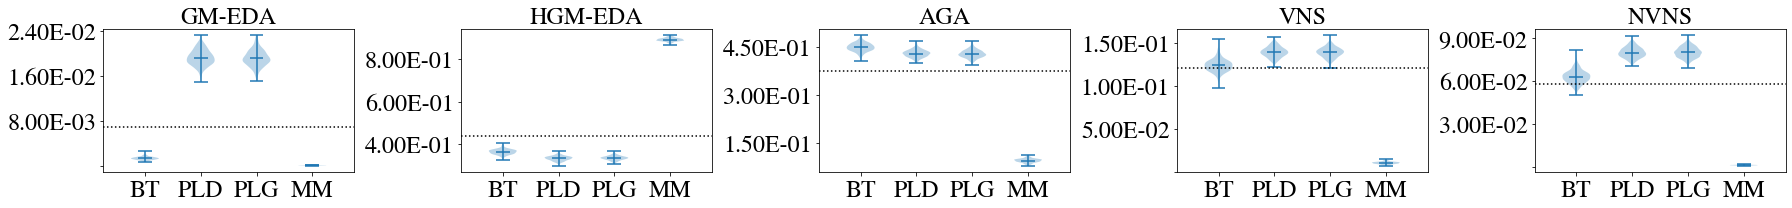

In [43]:
fig = plt.figure()
fig, axs = plt.subplots(1, 5, figsize=(25, 3))
flat_axs = axs

plotter = Plot()
plotter.plot_top_ranking_probs(model_names, algorithm_names, probs, p_top_ranking, flat_axs)

format_regular_coordinate_axis(flat_axs)
plt.tight_layout()

fig.savefig("img/TopOneReal.pdf", bbox_inches='tight')

**Numerical results:**

In [44]:
data = tabuleTopOne(probs)
index = model_names
df = pd.DataFrame(data, columns=algorithm_names, index=index)
df.to_latex("tables/TopOneReal.tex")
df

,GM-EDA,HGM-EDA,AGA,VNS,NVNS
BT,1.40E-03 (2.86E-04),3.62E-01 (1.23E-02),4.50E-01 (1.31E-02),1.23E-01 (7.35E-03),6.30E-02 (4.61E-03)
PLD,1.93E-02 (1.37E-03),3.32E-01 (1.12E-02),4.30E-01 (1.17E-02),1.39E-01 (6.16E-03),8.00E-02 (3.81E-03)
PLG,1.93E-02 (1.43E-03),3.33E-01 (1.02E-02),4.29E-01 (1.23E-02),1.39E-01 (5.92E-03),8.03E-02 (3.85E-03)
MM,1.23E-04 (3.60E-05),8.93E-01 (8.08E-03),9.58E-02 (6.34E-03),1.03E-02 (1.46E-03),1.12E-03 (2.44E-04)


**Probability of an algorithm to be better than another:**<a id="fig-7"></a>

Fig. 7: Probability of each algorithm to outperform others using the PSFP benchmark. In the first row, we show the results obtained with the BT model and in the second row for the MM. Each plot represents the probability that the algorithm in the center outperforms the other algorithms in the outer ring of the polar coordinate system.

In [53]:
probs = calculate_better_than_probs(orderings)

<Figure size 432x288 with 0 Axes>

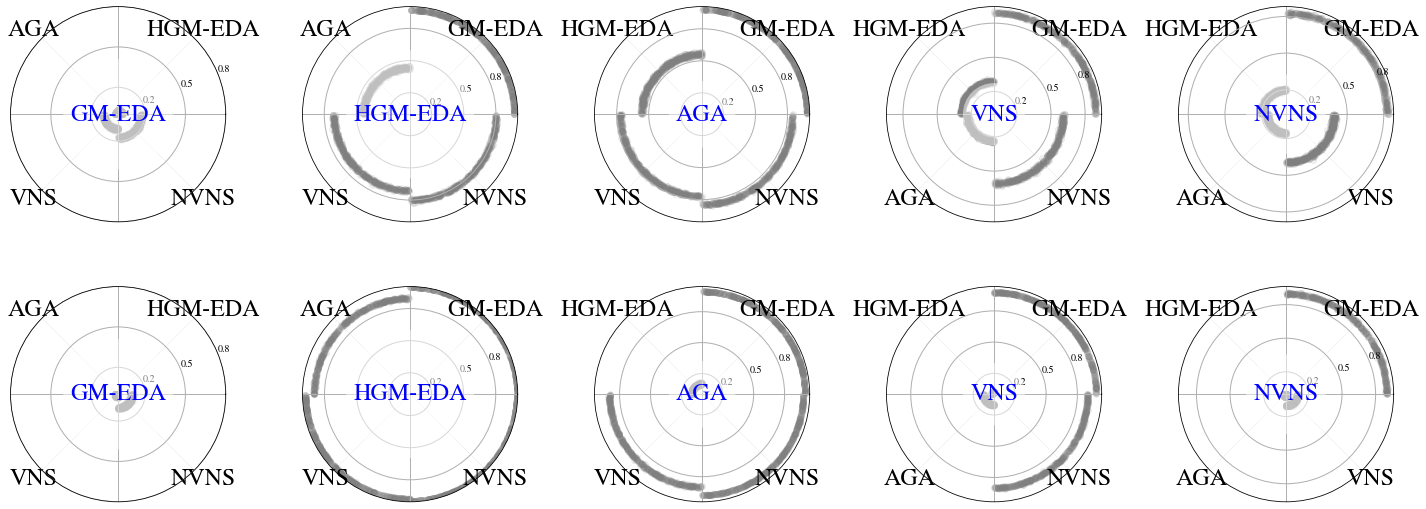

In [54]:
fig = plt.figure()
fig, axs = plt.subplots(2, 5, figsize=(20, 8), subplot_kw=dict(projection='polar'))

plotter = Plot()
plotter.plot_better_than_probs(algorithm_names, probs[0], p_better_than, axs[0])
plotter.plot_better_than_probs(algorithm_names, probs[3], p_better_than, axs[1])

format_polar_coordinate_axis(axs[0])
format_polar_coordinate_axis(axs[1])
plt.tight_layout()

fig.savefig("img/BetterThanReal.pdf", bbox_inches='tight')

**Numerical results:**

In [47]:
data = tabuleBetterThan(probs)
tuples = itertools.product(model_names, algorithm_names)
index = pd.MultiIndex.from_tuples(tuples, names=["Model", "Algorithm"])
df = pd.DataFrame(data, columns=algorithm_names, index=index)
df.to_latex("tables/BetterThanReal.tex")
df

GM-EDA              HGM-EDA  \
Model Algorithm                                             
BT    GM-EDA     0.00E+00 (0.00E+00)  3.04E-02 (3.47E-03)   
      HGM-EDA    9.70E-01 (3.47E-03)  0.00E+00 (0.00E+00)   
      AGA        9.79E-01 (2.37E-03)  5.53E-01 (1.43E-02)   
      VNS        8.91E-01 (7.53E-03)  2.89E-01 (1.28E-02)   
      NVNS       8.27E-01 (1.15E-02)  2.01E-01 (1.06E-02)   
PLD   GM-EDA     0.00E+00 (0.00E+00)  5.52E-02 (4.37E-03)   
      HGM-EDA    9.45E-01 (4.37E-03)  0.00E+00 (0.00E+00)   
      AGA        9.57E-01 (3.31E-03)  5.65E-01 (1.40E-02)   
      VNS        8.78E-01 (7.99E-03)  2.96E-01 (1.28E-02)   
      NVNS       8.05E-01 (1.12E-02)  1.95E-01 (1.01E-02)   
PLG   GM-EDA     0.00E+00 (0.00E+00)  5.47E-02 (4.37E-03)   
      HGM-EDA    9.45E-01 (4.37E-03)  0.00E+00 (0.00E+00)   
      AGA        9.57E-01 (3.52E-03)  5.63E-01 (1.36E-02)   
      VNS        8.78E-01 (8.14E-03)  2.94E-01 (1.15E-02)   
      NVNS       8.06E-01 (1.19E-02)  1.94E-01 (8.95E-03)   
MM    GM-EDA     0.00E+00 (0.00E+00)  4.76E-04 (1.38E-04)   
      HGM-EDA    1.00E+00 (1.38E-04)  0.00E+00 (0.00E+00)   
      AGA        9.97E-01 (6.91E-04)  9.70E-02 (6.59E-03)   
      VNS        9.80E-01 (2.72E-03)  1.97E-02 (2.72E-03)   
      NVNS       9.03E-01 (6.59E-03)  3.24E-03 (6.91E-04)   

                                 AGA                  VNS                 NVNS  
Model Algorithm                                                                 
BT    GM-EDA     2.07E-02 (2.37E-03)  1.09E-01 (7.53E-03)  1.73E-01 (1.15E-02)  
      HGM-EDA    4.47E-01 (1.43E-02)  7.11E-01 (1.28E-02)  7.99E-01 (1.06E-02)  
      AGA        0.00E+00 (0.00E+00)  7.56E-01 (1.21E-02)  8.37E-01 (9.68E-03)  
      VNS        2.44E-01 (1.21E-02)  0.00E+00 (0.00E+00)  6.06E-01 (1.42E-02)  
      NVNS       1.63E-01 (9.68E-03)  3.94E-01 (1.42E-02)  0.00E+00 (0.00E+00)  
PLD   GM-EDA     4.31E-02 (3.31E-03)  1.22E-01 (7.99E-03)  1.95E-01 (1.12E-02)  
      HGM-EDA    4.35E-01 (1.40E-02)  7.04E-01 (1.28E-02)  8.05E-01 (1.01E-02)  
      AGA        0.00E+00 (0.00E+00)  7.56E-01 (1.11E-02)  8.43E-01 (7.94E-03)  
      VNS        2.44E-01 (1.11E-02)  0.00E+00 (0.00E+00)  6.35E-01 (1.40E-02)  
      NVNS       1.57E-01 (7.94E-03)  3.65E-01 (1.40E-02)  0.00E+00 (0.00E+00)  
PLG   GM-EDA     4.30E-02 (3.52E-03)  1.22E-01 (8.14E-03)  1.94E-01 (1.19E-02)  
      HGM-EDA    4.37E-01 (1.36E-02)  7.06E-01 (1.15E-02)  8.06E-01 (8.95E-03)  
      AGA        0.00E+00 (0.00E+00)  7.56E-01 (1.14E-02)  8.42E-01 (8.68E-03)  
      VNS        2.44E-01 (1.14E-02)  0.00E+00 (0.00E+00)  6.33E-01 (1.36E-02)  
      NVNS       1.58E-01 (8.68E-03)  3.67E-01 (1.36E-02)  0.00E+00 (0.00E+00)  
MM    GM-EDA     3.24E-03 (6.91E-04)  1.97E-02 (2.72E-03)  9.70E-02 (6.59E-03)  
      HGM-EDA    9.03E-01 (6.59E-03)  9.80E-01 (2.72E-03)  9.97E-01 (6.91E-04)  
      AGA        0.00E+00 (0.00E+00)  9.03E-01 (6.59E-03)  9.80E-01 (2.72E-03)  
      VNS        9.70E-02 (6.59E-03)  0.00E+00 (0.00E+00)  9.03E-01 (6.59E-03)  
      NVNS       1.97E-02 (2.72E-03)  9.70E-02 (6.59E-03)  0.00E+00 (0.00E+00)

**Probability of an algorithm to be in the top-k ranking:**<a id="fig-8"></a>

Fig. [*]: Probability of each algorithm to be in the top-$k$ ranking using the PSFP benchmark. Each column represents a different value of $k$.

In [48]:
probs = calculate_top_k_probs(orderings)

<Figure size 432x288 with 0 Axes>

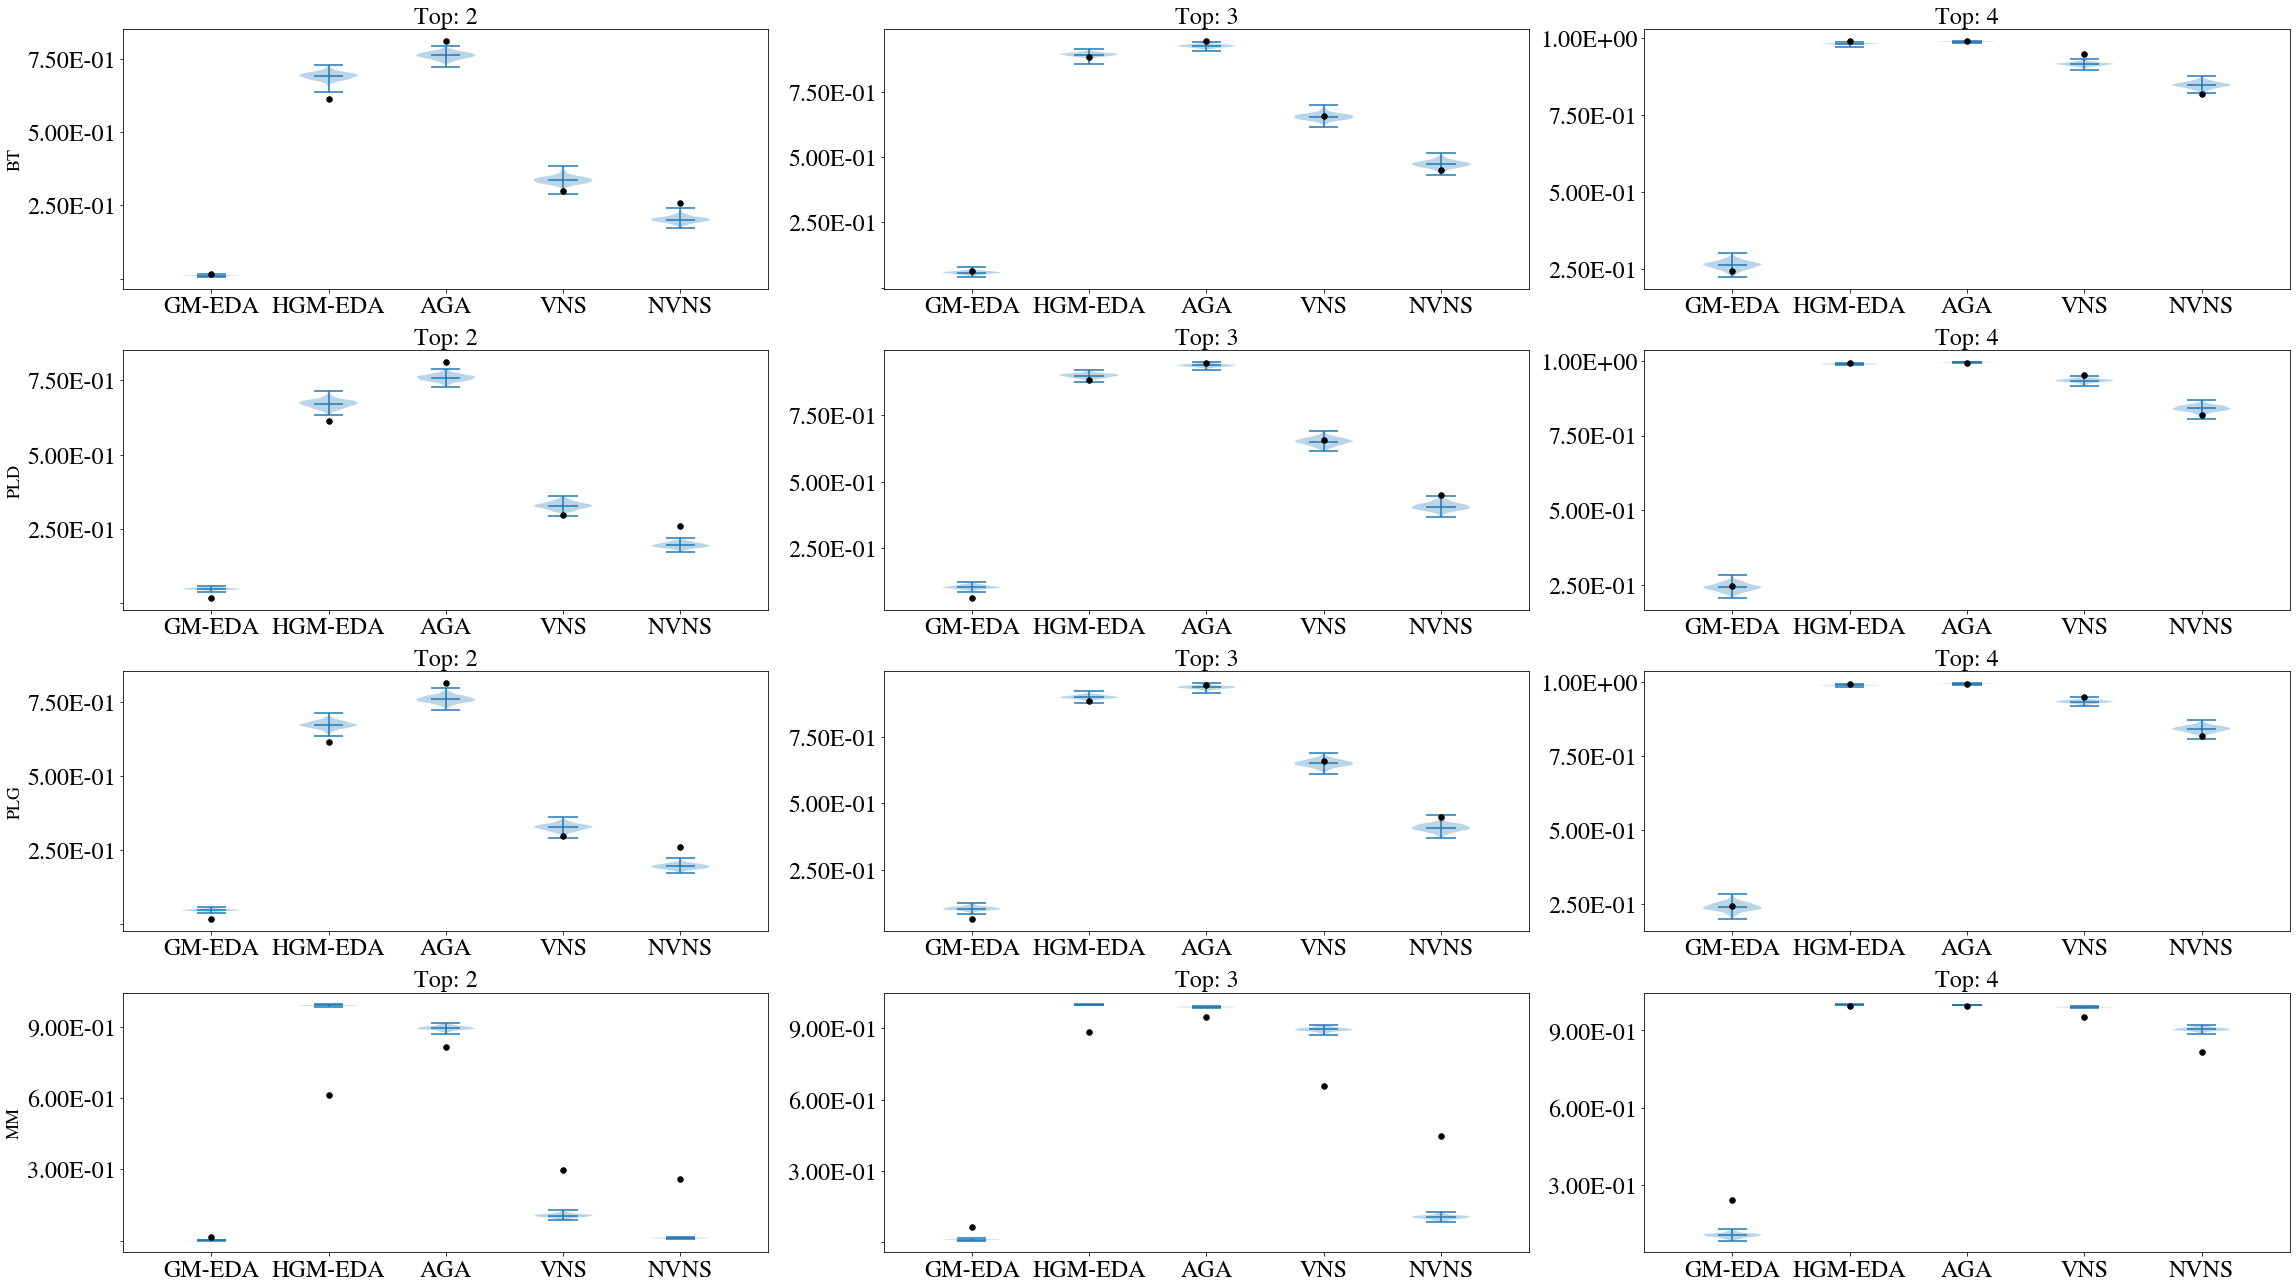

In [49]:
fig = plt.figure()
fig, axs = plt.subplots(4, 3, figsize=(32, 18))
flat_axs = list(itertools.chain.from_iterable(axs))

for i, row in enumerate(axs):
    row[0].set_ylabel(model_names[i], fontsize=18)
    flat_axs = [None] + list(row) + [None]
    plotter = Plot()
    plotter.plot_top_k_probs(algorithm_names, probs[i], p_top_k, flat_axs)
    format_regular_coordinate_axis(flat_axs)

plt.tight_layout()
fig.savefig("img/TopKReal.pdf", bbox_inches='tight')

**Numerical results:**

In [50]:
data = tabuleTopK(probs)
tuples = itertools.product(model_names, algorithm_names)
index = pd.MultiIndex.from_tuples(tuples, names=["Model", "Algorithm"])
df = pd.DataFrame(data, columns=["Top 2", "Top 3", "Top 4"], index=index)
df.to_latex("tables/TopKReal.tex")
df

Top 2                Top 3                Top 4
Model Algorithm                                                               
BT    GM-EDA     1.02E-02 (1.56E-03)  5.83E-02 (5.87E-03)  2.63E-01 (1.35E-02)
      HGM-EDA    6.91E-01 (1.26E-02)  8.92E-01 (7.10E-03)  9.83E-01 (1.93E-03)
      AGA        7.62E-01 (1.16E-02)  9.24E-01 (5.66E-03)  9.89E-01 (1.23E-03)
      VNS        3.36E-01 (1.30E-02)  6.54E-01 (1.25E-02)  9.17E-01 (5.49E-03)
      NVNS       2.01E-01 (1.03E-02)  4.72E-01 (1.39E-02)  8.49E-01 (9.74E-03)
PLD   GM-EDA     4.84E-02 (3.30E-03)  1.05E-01 (6.50E-03)  2.42E-01 (1.30E-02)
      HGM-EDA    6.71E-01 (1.36E-02)  8.99E-01 (7.81E-03)  9.89E-01 (1.43E-03)
      AGA        7.59E-01 (1.12E-02)  9.37E-01 (5.08E-03)  9.94E-01 (7.44E-04)
      VNS        3.28E-01 (1.20E-02)  6.52E-01 (1.38E-02)  9.34E-01 (5.57E-03)
      NVNS       1.95E-01 (8.38E-03)  4.07E-01 (1.37E-02)  8.40E-01 (1.00E-02)
PLG   GM-EDA     4.81E-02 (3.45E-03)  1.05E-01 (6.82E-03)  2.41E-01 (1.38E-02)
      HGM-EDA    6.72E-01 (1.17E-02)  9.00E-01 (6.75E-03)  9.89E-01 (1.31E-03)
      AGA        7.58E-01 (1.21E-02)  9.37E-01 (5.59E-03)  9.94E-01 (8.14E-04)
      VNS        3.27E-01 (1.14E-02)  6.51E-01 (1.32E-02)  9.34E-01 (5.46E-03)
      NVNS       1.95E-01 (8.27E-03)  4.08E-01 (1.35E-02)  8.41E-01 (1.05E-02)
MM    GM-EDA     1.25E-03 (2.79E-04)  1.16E-02 (1.74E-03)  1.07E-01 (8.08E-03)
      HGM-EDA    9.88E-01 (1.74E-03)  9.99E-01 (2.79E-04)  1.00E+00 (3.60E-05)
      AGA        8.94E-01 (7.81E-03)  9.89E-01 (1.70E-03)  9.99E-01 (2.44E-04)
      VNS        1.05E-01 (7.57E-03)  8.95E-01 (7.57E-03)  9.90E-01 (1.46E-03)
      NVNS       1.15E-02 (1.70E-03)  1.06E-01 (7.81E-03)  9.04E-01 (6.34E-03)

**Sensibility analysis:**<a id="fig-9"></a>

Fig. 8. Probability of algorithm GM-EDA to be the top-ranked algorithm as we take different numbers of permutations to perform the Bayesian inferences, i.e., $p=\{100, 500, 1000, 2000\}$

In [51]:
probs_per_sample = []
buckets = [100, 500, 1000, 2000]
for num_samples in buckets:
    # Load the data from file
    orderingsT, scoresT = load_permus_from_CEB('data/CEB19/T', algorithms)
    orderingsR, scoresR = load_permus_from_CEB('data/CEB19/R', algorithms)

    # Concatenate Taillard instances with the Random instances
    orderings = np.concatenate((orderingsT, orderingsR), axis=0)
    orderings = sample_permus(orderings, num_samples)
    rankings = np.argsort(orderings, axis=1) + 1
    
    probs = calculate_top_ranking_probs(orderings)
    probs_per_sample.append(probs)

<Figure size 432x288 with 0 Axes>

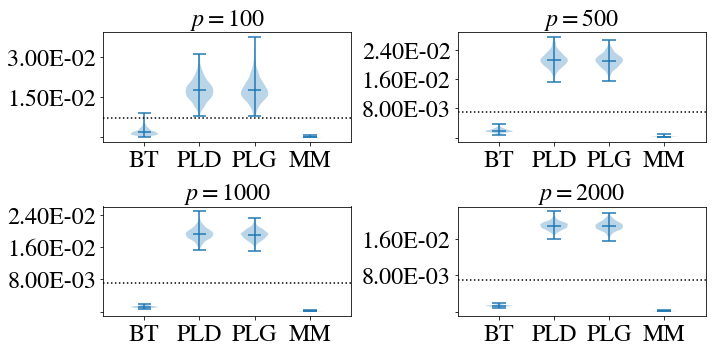

In [52]:
fig = plt.figure()
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
flat_axs = list(itertools.chain.from_iterable(axs))
plotter = Plot()

for i, probs in enumerate(probs_per_sample):
    custom_ax = [flat_axs[i], None, None, None, None]
    plotter.plot_top_ranking_probs(model_names, algorithm_names, probs, p_top_ranking, custom_ax)
    flat_axs[i].set_title("$p=" + str(buckets[i]) + "$")

format_regular_coordinate_axis(flat_axs)
plt.tight_layout()

fig.savefig("img/TopOneSensibilityGMEDA.pdf", bbox_inches='tight')